<a href="https://colab.research.google.com/github/adhish-bahl/2347203_NNDL_Lab/blob/main/2347203_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Importing Libraries**

In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### **Loading Dataset**

In [18]:
(ds_train, ds_test), ds_info = tfds.load('kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

#### **Data Preprocessing**

**Normalize the data (pixel values between 0 and 1)**

In [19]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label

In [20]:
batch_size = 32
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(batch_size)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)

**Convert dataset to numpy arrays**

In [21]:
def dataset_to_numpy(dataset):
    X, y = [], []
    for images, labels in dataset:
        X.extend(images.numpy())
        y.extend(labels.numpy())
    return np.array(X), np.array(y)

**Convert training and test datasets to NumPy arrays**

In [22]:
X_train, y_train = dataset_to_numpy(ds_train)
X_test, y_test = dataset_to_numpy(ds_test)

**Split the training data into training and validation sets (80% training, 20% validation)**

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

**Flatten the images to shape (batch_size, 784)**

In [24]:
X_train = X_train.reshape(-1, 784)
X_val = X_val.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

**Determine the centers using K-means clustering**

In [25]:
num_units = 100
kmeans = KMeans(n_clusters=num_units, random_state=42).fit(X_train)
centers = kmeans.cluster_centers_

#### **Radial Basis Function (RBF) Network**

In [26]:
class RBFNetwork(tf.keras.Model):
    def __init__(self, num_units, num_classes, centers):
        super(RBFNetwork, self).__init__()
        self.num_units = num_units
        self.num_classes = num_classes
        self.centers = tf.Variable(centers, trainable=False)
        self.beta = tf.Variable(tf.ones([self.num_units]), trainable=True)
        self.W = tf.Variable(tf.random.normal([self.num_units, self.num_classes]))

    def rbf(self, X):
        diff = tf.expand_dims(X, 1) - tf.expand_dims(self.centers, 0)
        distance_squared = tf.reduce_sum(tf.square(diff), axis=-1)
        return tf.exp(-self.beta * distance_squared)

    def call(self, X):
        rbf_output = self.rbf(X)
        return tf.nn.softmax(tf.matmul(rbf_output, self.W))

num_classes = 10
rbf_network = RBFNetwork(num_units, num_classes, centers)

learning_rate = 0.01
rbf_network.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

#### **Training**

In [27]:
history = rbf_network.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
   1/1500 ━━━━━━━━━━━━━━━━━━━━ 6:57 278ms/step - accuracy: 0.1562 - loss: 2.3026

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0991 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1019 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.1046 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.0997 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1009 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.1032 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.0999 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.1006 - loss: 2.3026 

#### **Evaluation**

**Compute accuracy**

In [28]:
test_loss, test_accuracy = rbf_network.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0982 - loss: 2.3026
Test Loss: 2.30259108543396
Test Accuracy: 0.10029999911785126


**Print final training accuracy**

In [29]:
final_train_accuracy = history.history['accuracy'][-1]
print("Final Training Accuracy:", final_train_accuracy)

Final Training Accuracy: 0.10104166716337204


**Plot training and validation accuracy**

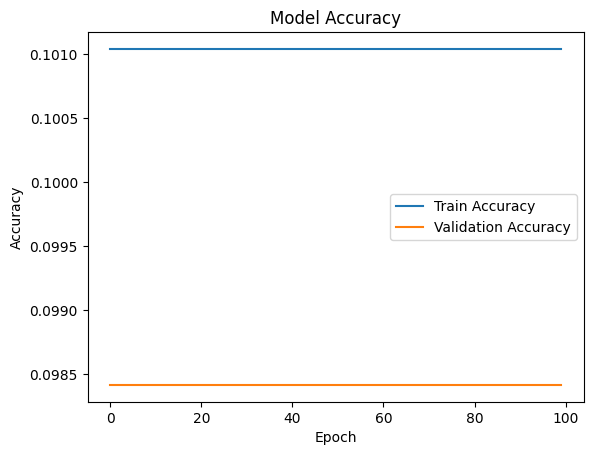

In [30]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**Plot training and validation loss**

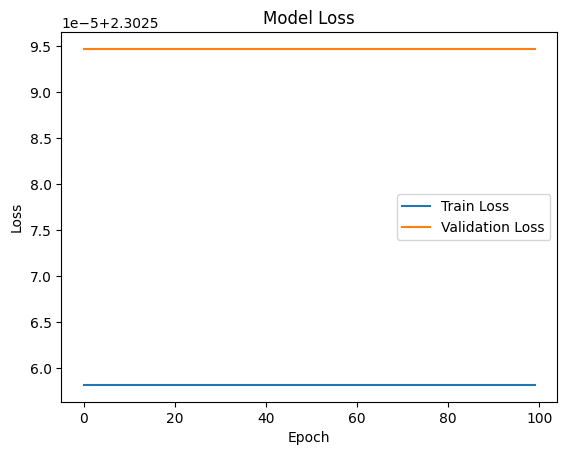

In [31]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**Plot confusion matrix**

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


<Figure size 1000x700 with 0 Axes>

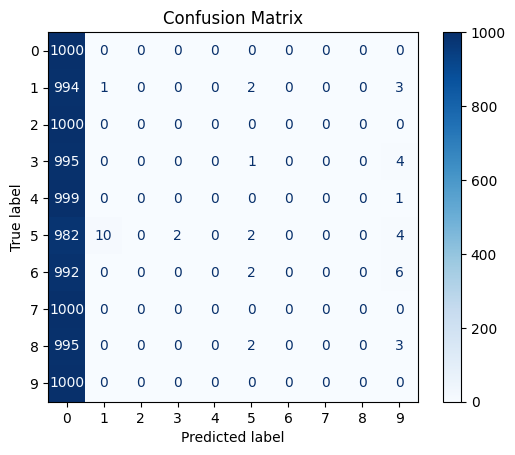

In [32]:
y_pred = np.argmax(rbf_network.predict(X_test), axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes)).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


#### **Analysis**

**Compute accuracy**

With a test loss of 2.3026 and an accuracy of roughly 10%, the test results show that the model performs quite poorly. Given that 10% accuracy is what one would anticipate from randomly selecting one of the dataset's ten classes, this indicates that the model is operating at the level of random guessing. This is further supported by the loss value, which is near the natural log of 10.

**Plot training and validation accuracy**

From the plot, it's evident that both training accuracy (blue line) and validation accuracy (orange line) remain stagnant throughout the entire training process. The training accuracy hovers around 10.1%, while the validation accuracy is just below 10%. These values are indicative of random guessing, which is expected for a classification problem with 10 classes, where a model that hasn't learned anything will achieve roughly 10% accuracy by chance.

**Plot training and validation loss**

The plot indicates that the model is not learning effectively, with a large discrepancy between training and validation loss, and the lack of improvement across epochs suggests that further tuning of the model and training setup is required.

**Plot confusion matrix**

The confusion matrix highlights severe issues with the model's classification ability. It predominantly predicts class 0 for almost every input, which aligns with the low accuracy observed earlier (around 10%, equivalent to random guessing). This strongly suggests that the model is not learning useful features from the data and is unable to differentiate between the 10 classes.